# Assignment 4 (ML-II)

# Fraud Detection Clustering (Example 2)

## Wali Ullah (09745)

In [81]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [82]:
#conda install -c conda-forge imbalanced-learn

In [83]:
#!pip install -U gensim

In [84]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN
import gensim
from gensim import corpora
#import performance scores
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.cluster import KMeans
from sklearn.cluster import OPTICS
import scipy.cluster.hierarchy as sch
from matplotlib import pyplot

In [85]:
# Load Data
def load_data(file_name):
    def readcsv(file_name):
        return pd.read_csv(file_name)
    def readexcel(file_name):
        return pd.read_excel(file_name)
    func_map = {
        "csv": readcsv,
        "xlsx": readexcel,
    }
    
    # default reader = readcsv
    reader = func_map.get("csv")
    
    for k,v in func_map.items():
        if file_name.endswith(k):
            reader = v
            break
    return reader(file_name)

FILE_NAME = "banksim_adj.csv"

LABEL_COL = "fraud"
banksim_adj_df = load_data(FILE_NAME)
display(banksim_adj_df.head())
print(banksim_adj_df.shape)
print(banksim_adj_df.dtypes)

,age,amount,fraud,M,es_barsandrestaurants,es_contents,es_fashion,es_food,es_health,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel
0,3,49.71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,39.29,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,18.76,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,13.95,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,49.87,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


(7189, 18)
age                        int64
amount                   float64
fraud                      int64
M                          int64
es_barsandrestaurants      int64
es_contents                int64
es_fashion                 int64
es_food                    int64
es_health                  int64
es_home                    int64
es_hotelservices           int64
es_hyper                   int64
es_leisure                 int64
es_otherservices           int64
es_sportsandtoys           int64
es_tech                    int64
es_transportation          int64
es_travel                  int64
dtype: object


## Data Set

In [86]:

banksim_adj_df

,age,amount,fraud,M,es_barsandrestaurants,es_contents,es_fashion,es_food,es_health,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel
0,3,49.7100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,4,39.2900,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,18.7600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,13.9500,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2,49.8700,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7184,5,236.1474,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7185,5,139.6000,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
7186,1,236.1474,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7187,1,236.1474,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [87]:
#cols = ['customer' , 'age' , 'gender' , 'zipcodeOri' , 'merchant' , 'zipMerchant' , 'category' , 'amount' , 'fraud']

In [88]:
labels = banksim_adj_df.fraud
y=labels
y

0       0
1       0
2       0
3       0
4       0
       ..
7184    1
7185    1
7186    1
7187    1
7188    1
Name: fraud, Length: 7189, dtype: int64

In [89]:
cols = ['age', 'amount', 'M', 'es_barsandrestaurants', 'es_contents',
        'es_fashion', 'es_food', 'es_health', 'es_home', 'es_hotelservices',
        'es_hyper', 'es_leisure', 'es_otherservices', 'es_sportsandtoys',
        'es_tech', 'es_transportation', 'es_travel']

In [90]:
# Take the float values of df for X
X = banksim_adj_df[cols].values.astype(np.float)

In [91]:
X.shape

(7189, 17)

In [92]:
X

array([[  3.    ,  49.71  ,   0.    , ...,   0.    ,   1.    ,   0.    ],
       [  4.    ,  39.29  ,   0.    , ...,   0.    ,   0.    ,   0.    ],
       [  3.    ,  18.76  ,   0.    , ...,   0.    ,   1.    ,   0.    ],
       ...,
       [  1.    , 236.1474,   0.    , ...,   0.    ,   0.    ,   1.    ],
       [  1.    , 236.1474,   1.    , ...,   0.    ,   0.    ,   0.    ],
       [  4.    , 236.1474,   0.    , ...,   0.    ,   0.    ,   0.    ]])

In [93]:
# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X=X_scaled
X

array([[0.5       , 0.20681002, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.66666667, 0.16247858, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.07513457, 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.16666667, 1.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.16666667, 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.66666667, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

# Clustering Algrothams

# K-Mean

In [94]:
# Define the model 
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)
# Fit the model to the scaled data
kmeans.fit(X_scaled)

MiniBatchKMeans(random_state=0)

In [95]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

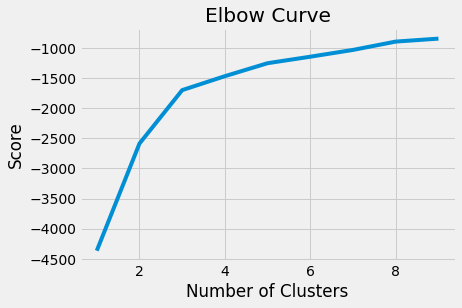

In [96]:
# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [97]:
from sklearn.cluster import KMeans
# Run the kmeans model on scaled data
kmeans = KMeans(n_clusters=6, random_state=42,n_jobs=-1).fit(X_scaled)

# Get the cluster number for each datapoint
X_clusters = kmeans.predict(X_scaled)

# Save the cluster centroids
X_clusters_centers = kmeans.cluster_centers_

# Calculate the distance to the cluster centroid for each point
dist = [np.linalg.norm(x-y) for x,y in zip(X_scaled, X_clusters_centers[X_clusters])]

# Create predictions based on distance
km_y_pred = np.array(dist)
km_y_pred[dist>=np.percentile(dist, 93)] = 1
km_y_pred[dist<np.percentile(dist, 93)] = 0

In [98]:
# Split the data into training and test set
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, labels, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X)

# Obtain predictions and calculate distance from cluster centroid
X_clusters = kmeans.predict(X)
X_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X, X_clusters_centers[X_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

## Checking model results

#### Validating the Model Results

* without fraud labels, the usual performance metrics can't be run
    * check with the fraud analyst
    * investigate and describe cases that are flagged in more detail
        * is it fraudulent or just a rare case of legit data
        * avoid rare, legit cases by deleting certain features or removing the cases from the data
    * if there are past cases of fraud, see if the model can predict them using historic data

In [99]:
def plot_confusion_matrix(cm, classes=['Not Fraud', 'Fraud'],
                          normalize=False,
                          title='Fraud Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-
        examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Obtain the ROC score
def roc_score(y, yhat):
    roc_auc_score(y, yhat)
    accuracy = accuracy_score(y, yhat)*100
    precision = precision_score(y, yhat, pos_label=1, labels=[0,1])*100
    recall = recall_score(y, yhat,pos_label=1,labels=[0,1])*100
    fpr , tpr, _ = roc_curve(y, yhat)
    auc_val = auc(fpr, tpr)
    f_score = f1_score(y, yhat)
    print('accuracy =', accuracy, 'precision=',precision, 'recall=',recall, 'auc_val=',auc_val, 'f_score=',f_score)


In [100]:
# Obtain the ROC score
roc_score(y, km_y_pred)

accuracy = 95.74349700931978 precision= 35.27777777777778 recall= 63.5 auc_val= 0.8008309486335671 f_score= 0.45357142857142857


Confusion matrix, without normalization


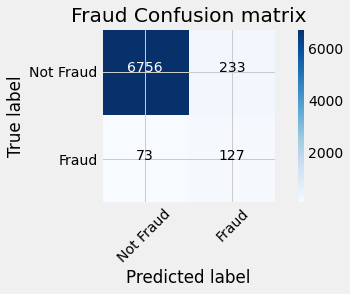

In [101]:
# Create a confusion matrix
km_cm = confusion_matrix(y, km_y_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)     

The results seems reasonably well, however, If you were to decrease the percentile used as a cutoff point in the previous exercise to 93% instead of 95%, what would that do to your prediction results?

The number of fraud cases caught increases, but false positives also increase.**

# Mini-Batch K-Means

In [102]:

# mini-batch k-means clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import MiniBatchKMeans
from matplotlib import pyplot
# define dataset
#X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# define the model
model = MiniBatchKMeans(n_clusters=2)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)


In [103]:
# Obtain the ROC score
roc_score(y, km_y_pred)

accuracy = 95.74349700931978 precision= 35.27777777777778 recall= 63.5 auc_val= 0.8008309486335671 f_score= 0.45357142857142857


Confusion matrix, without normalization


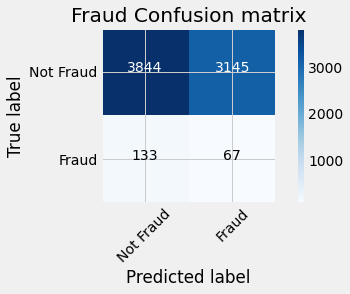

In [104]:
# Create a confusion matrix
km_cm = confusion_matrix(y, yhat)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm) 

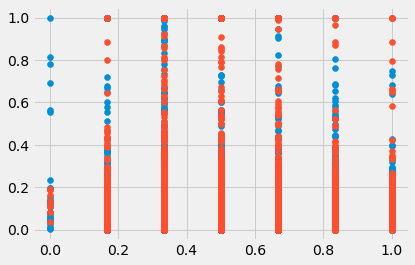

In [105]:
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

# Hierarchial Clustering

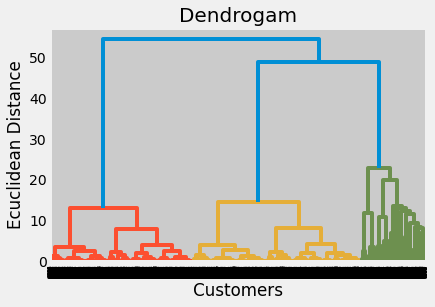

In [106]:
import scipy.cluster.hierarchy as sch

dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Dendrogam', fontsize = 20)
plt.xlabel('Customers')
plt.ylabel('Ecuclidean Distance')
plt.show()

accuracy = 59.465850605091106 precision= 0.0 recall= 0.0 auc_val= 0.30583774502790095 f_score= 0.0
Confusion matrix, without normalization


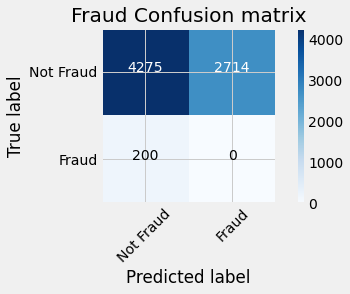

In [107]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)

# Obtain the ROC score
roc_score(y, y_hc)

km_cm = confusion_matrix(labels, y_hc)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)



# DBSCAN

In [108]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5, min_samples=10, n_jobs=-1).fit(X_scaled)

In [109]:
# Get the cluster labels (aka numbers)
pred_labels = db.labels_

# Count the total number of clusters
n_clusters_ = len(set(pred_labels)) - (1 if -1 in pred_labels else 0)

# Print model results
print(f'Estimated number of clusters: {n_clusters_}')

Estimated number of clusters: 22


In [110]:
import sklearn.metrics as metrics

In [111]:
# Print model results
print(f'Silhouette Coefficient: {metrics.silhouette_score(X_scaled, pred_labels):0.3f}')

Silhouette Coefficient: 0.712


In [112]:
# Get sample counts in each cluster 
counts = np.bincount(pred_labels[pred_labels>=0])
print(counts)

[3252  145 2714   55  174  119  122   98   54   13   76   43   25   51
   47   42   15   15   19   23   18   10]


### DB scan

In [113]:
# Initialize and fit the DBscan model
db = DBSCAN(eps=0.9, min_samples=10, n_jobs=-1).fit(X_scaled)

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in labels else 0)

In [114]:
# Print performance metrics for DBscan
print(f'Estimated number of clusters: {n_clusters}')
print(f'Homogeneity: {homogeneity_score(labels, pred_labels):0.3f}')
print(f'Silhouette Coefficient: {silhouette_score(X_scaled, pred_labels):0.3f}')

Estimated number of clusters: 23
Homogeneity: 0.612
Silhouette Coefficient: 0.713


### Assessing smallest clusters

In [115]:
# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels >= 0])

# Print the result
print(counts)

[3252  145 2714   55  174  119  122   98   54   15   76   15   43   25
   51   47   42   15   25   20   19   10]


In [116]:
# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]

In [117]:
# Print the results 
print(f'The smallest clusters are clusters: {smallest_clusters}')

The smallest clusters are clusters: [21 17  9]


In [118]:
# Print the counts of the smallest clusters only
print(f'Their counts are: {counts[smallest_clusters]}')

Their counts are: [10 15 15]


In [119]:
# Create a dataframe of the predicted cluster numbers and fraud labels 
df = pd.DataFrame({'clusternr':pred_labels,'fraud':labels})
yhat=np.where((df['clusternr'].isin([21, 17, 9])), 1 , 0)
# Create a condition flagging fraud for the smallest clusters 
#df['predicted_fraud'] = np.where((df['clusternr'].isin([21, 17, 9])), 1 , 0)

### Results verification

accuracy = 97.32925302545556 precision= 60.0 recall= 12.0 auc_val= 0.5588553441121764 f_score= 0.19999999999999998
Confusion matrix, without normalization


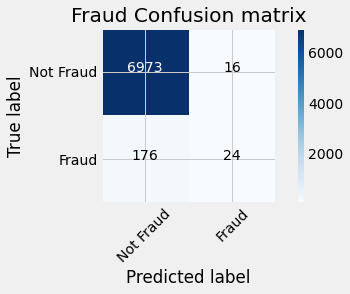

In [120]:
# Obtain the ROC score
roc_score(y, yhat)

km_cm = confusion_matrix(labels, yhat)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)

# Spectral Clustering

accuracy = 45.5974405341494 precision= 3.3442293185818457 recall= 66.5 auc_val= 0.5574964229503505 f_score= 0.06368206847019392
Confusion matrix, without normalization


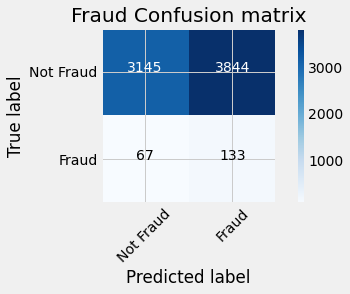

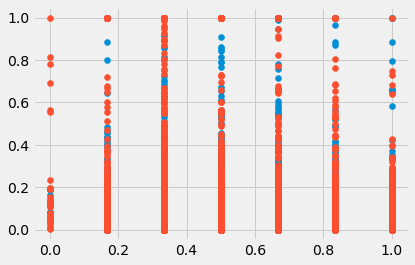

In [121]:
# spectral clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import SpectralClustering
from matplotlib import pyplot
# define dataset
#X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# define the model
model = SpectralClustering(n_clusters=2)
# fit model and predict clusters
yhat = model.fit_predict(X)
# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
# Obtain the ROC score
roc_score(y, yhat)

km_cm = confusion_matrix(labels, yhat)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)


for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

# Gaussian Mixture Model

accuracy = 45.5974405341494 precision= 3.3442293185818457 recall= 66.5 auc_val= 0.5574964229503505 f_score= 0.06368206847019392
Confusion matrix, without normalization


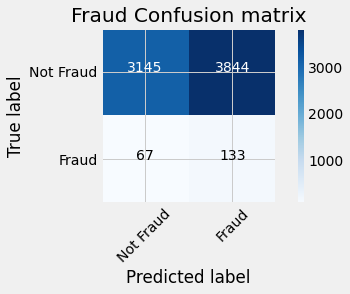

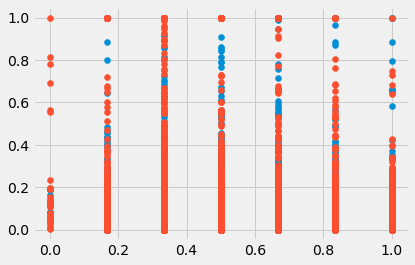

In [122]:
# gaussian mixture clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot
# define dataset
#X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# define the model
model = GaussianMixture(n_components=2)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)
# retrieve unique clusters
clusters = unique(yhat)


# Obtain the ROC score
roc_score(y, yhat)

km_cm = confusion_matrix(labels, yhat)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)


# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

# BIRCH

accuracy = 14.23007372374461 precision= 0.0 recall= 0.0 auc_val= 0.07318643582772927 f_score= 0.0
Confusion matrix, without normalization


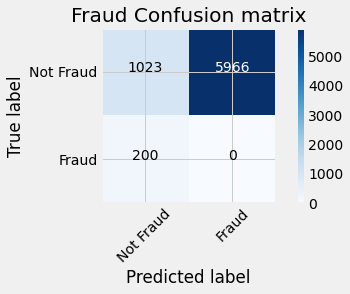

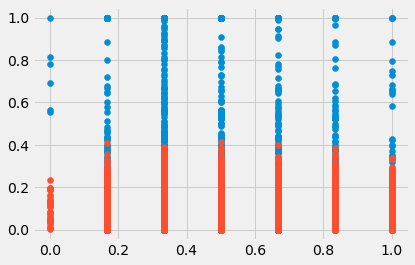

In [123]:
# birch clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import Birch
from matplotlib import pyplot
# define dataset
#X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# define the model
model = Birch(threshold=0.01, n_clusters=2)
# fit the model
model.fit(X)
# assign a cluster to each example
yhat = model.predict(X)



# Obtain the ROC score
roc_score(y, yhat)

km_cm = confusion_matrix(labels, yhat)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)


# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

# Agglomerative Clustering

accuracy = 59.465850605091106 precision= 0.0 recall= 0.0 auc_val= 0.30583774502790095 f_score= 0.0
Confusion matrix, without normalization


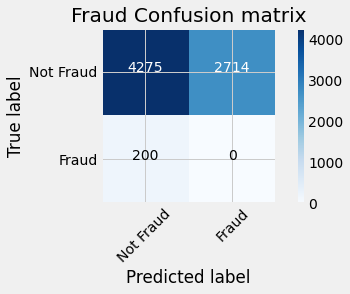

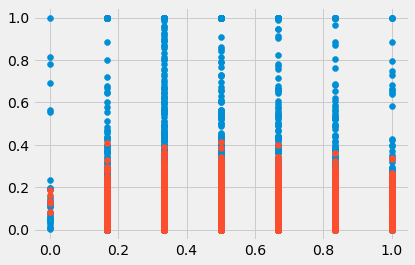

In [124]:
# agglomerative clustering
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot
# define dataset
#X, _ = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=4)
# define the model
model = AgglomerativeClustering(n_clusters=2)
# fit model and predict clusters
yhat = model.fit_predict(X)



# Obtain the ROC score
roc_score(y, yhat)

km_cm = confusion_matrix(labels, yhat)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)

# retrieve unique clusters
clusters = unique(yhat)
# create scatter plot for samples from each cluster
for cluster in clusters:
	# get row indexes for samples with this cluster
	row_ix = where(yhat == cluster)
	# create scatter of these samples
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show the plot
pyplot.show()

# Affinity Propagation

# Clustering Setup for Binary Outcome with Observed Label

In [125]:
def plot_confusion_matrix(cm, classes=['No', 'Yes'],
                          normalize=False,
                          title='Fraud Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    From:
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-
        examples-model-selection-plot-confusion-matrix-py
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [126]:
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, SpectralClustering

def clusteralg_binary_class(X,y): 
    algorithms = []
    algorithms.append(KMeans(n_clusters=2, init = 'k-means++', max_iter = 300, n_init = 10, random_state=1))
    algorithms.append(AgglomerativeClustering(n_clusters=2))
    #algorithms.append(AffinityPropagation(damping=0.9))
    algorithms.append(SpectralClustering(n_clusters=2, random_state=1,
                                     affinity='nearest_neighbors'))
    
    #algorithms.append(DBSCAN(eps=0.9, min_samples=2, n_jobs=1).fit(X))
    #algorithms.append(OPTICS(eps=0.8, min_samples=10))
    #algorithms.append(GaussianMixture(n_components=2))
    algorithms.append(MiniBatchKMeans(n_clusters=2))
    algorithms.append(Birch(threshold=0.01, n_clusters=2))
    algorithms.append(AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward'))
    
    data1 = []
    for algo in algorithms:
        algo.fit(X)
        if algo=='AffinityPropagation':
            clusters = unique(algo.labels_)
            
        accuracy = accuracy_score(y, algo.labels_)*100
        precision = precision_score(y, algo.labels_, pos_label=1, labels=[0,1])*100
        recall = recall_score(y, algo.labels_,pos_label=1,labels=[0,1])*100
        fpr , tpr, _ = roc_curve(y, algo.labels_)
        auc_val = auc(fpr, tpr)
        f_score = f1_score(y, algo.labels_)
        print(algo)
        print('accuracy =', accuracy, 'precision=',precision, 'recall=',recall, 'auc_val=',auc_val, 'f_score=',f_score)
        km_cm = confusion_matrix(y, algo.labels_)

        # Plot the confusion matrix in a figure to visualize results 
        plot_confusion_matrix(km_cm)
    
    
        data1.append(({
            'ARI': metrics.adjusted_rand_score(y, algo.labels_),
            'AMI': metrics.adjusted_mutual_info_score(y, algo.labels_,
                                                 average_method='arithmetic'),
            'Homogenity': metrics.homogeneity_score(y, algo.labels_),
            'Completeness': metrics.completeness_score(y, algo.labels_),
            'V-measure': metrics.v_measure_score(y, algo.labels_),
            'accuracy':metrics.accuracy_score(y, algo.labels_)*100,
            'precision': metrics.precision_score(y, algo.labels_, pos_label=1, labels=[0,1])*100,
            'recall': metrics.recall_score(y, algo.labels_,pos_label=1,labels=[0,1])*100,
            #fpr , tpr, _ = roc_curve(y, algo.labels_)
            #'auc_val':metrics.auc(fpr, tpr),
            'f_score': metrics.f1_score(y, algo.labels_)
            
            #,
            #'Silhouette': metrics.silhouette_score(X, algo.labels_)
        }))

    results = pd.DataFrame(data=data1, columns=['ARI', 'AMI', 'Homogenity', 'Completeness', 'V-measure','accuracy',
                                                'precision','recall','f_score',
                                               #'auc_val','Silhouette'
                                               ],
                       index=['K-means', 'Agglomerative',#'Affinity', 
                              'Spectral',#'DBSCAN','OPTICS',
                              #'GaussianMixture',
                              'MiniBatchKMeans','Birch',
                             'AgglomerativeClustering'])
    
    return results
#print(f'Silhouette Coefficient: {silhouette_score(X_scaled, pred_labels):0.3f}')

KMeans(n_clusters=2, random_state=1)
accuracy = 45.5974405341494 precision= 3.3442293185818457 recall= 66.5 auc_val= 0.5574964229503505 f_score= 0.06368206847019392
Confusion matrix, without normalization


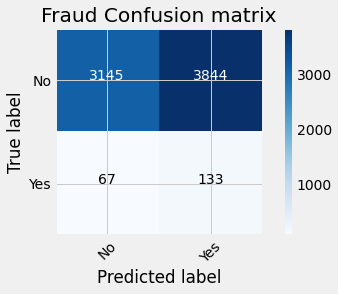

AgglomerativeClustering()
accuracy = 59.465850605091106 precision= 0.0 recall= 0.0 auc_val= 0.30583774502790095 f_score= 0.0
Confusion matrix, without normalization


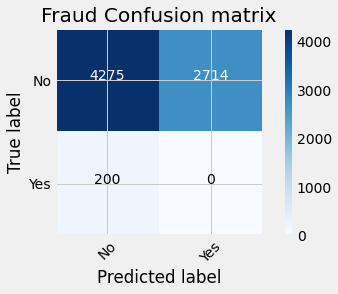

SpectralClustering(affinity='nearest_neighbors', n_clusters=2, random_state=1)
accuracy = 97.06496035609959 precision= 0.0 recall= 0.0 auc_val= 0.4992130490771212 f_score= 0.0
Confusion matrix, without normalization


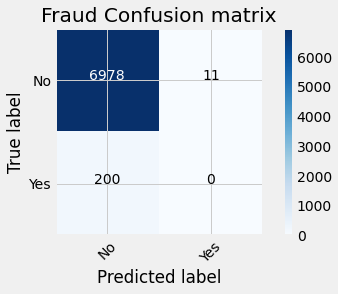

MiniBatchKMeans(n_clusters=2)
accuracy = 45.5974405341494 precision= 3.3442293185818457 recall= 66.5 auc_val= 0.5574964229503505 f_score= 0.06368206847019392
Confusion matrix, without normalization


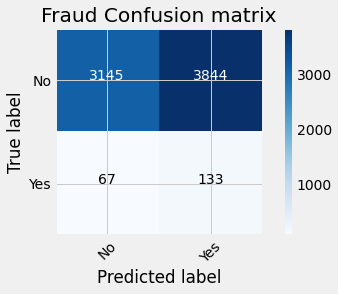

Birch(n_clusters=2, threshold=0.01)
accuracy = 14.23007372374461 precision= 0.0 recall= 0.0 auc_val= 0.07318643582772927 f_score= 0.0
Confusion matrix, without normalization


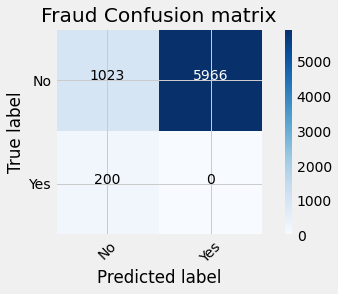

AgglomerativeClustering()
accuracy = 59.465850605091106 precision= 0.0 recall= 0.0 auc_val= 0.30583774502790095 f_score= 0.0
Confusion matrix, without normalization


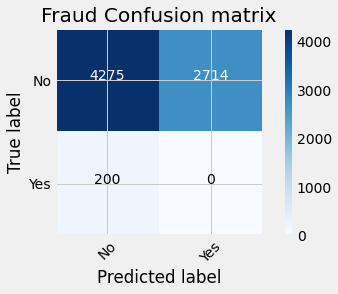

In [127]:
res=clusteralg_binary_class(X,y)

In [128]:
res

,ARI,AMI,Homogenity,Completeness,V-measure,accuracy,precision,recall,f_score
K-means,-0.002385,0.001650,0.005834,0.001079,0.001821,45.597441,3.344229,66.5,0.063682
Agglomerative,-0.018686,0.033829,0.105669,0.020259,0.034000,59.465851,0.000000,0.0,0.000000
Spectral,-0.002822,-0.000247,0.000340,0.003774,0.000624,97.064960,0.000000,0.0,0.000000
MiniBatchKMeans,-0.002385,0.001650,0.005834,0.001079,0.001821,45.597441,3.344229,66.5,0.063682
Birch,0.202021,0.175726,0.403646,0.112472,0.175924,14.230074,0.000000,0.0,0.000000
AgglomerativeClustering,-0.018686,0.033829,0.105669,0.020259,0.034000,59.465851,0.000000,0.0,0.000000


# Conclusion

Overall the results shows that the DBSCAN outperform all the remaining methods by putting the thershold level of 95%. The K-Mean results are also reasonably well, however the remaining clustering methods perform very poorly.